In [1]:
import torch
import numpy as np
from torchtext.legacy import data
from torchtext.legacy import datasets

In [2]:
TEXT = data.Field(tokenize = 'spacy', tokenizer_language = 'en_core_web_sm', include_lengths = True)
LABEL = data.LabelField(dtype = torch.float)

fields = [('text', TEXT), ('label', LABEL)]
train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = 'dataset_2class',
                                        train = 'train.csv',
                                        validation = 'valid.csv',
                                        test = 'test.csv',
                                        format = 'csv',
                                        fields = fields,
)

In [3]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 4549
Number of validation examples: 800
Number of testing examples: 800


In [4]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE, vectors = "glove.twitter.27B.100d", unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

In [5]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 12817
Unique tokens in LABEL vocabulary: 2


In [6]:
print(TEXT.vocab.itos[:10])
print(LABEL.vocab.stoi)

['<unk>', '<pad>', 'the', 'to', 'of', 'coronavirus', ',', 'in', 'a', 'and']
defaultdict(None, {'0': 0, '1': 1})


In [7]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x : len(x.text),
    sort_within_batch = True,
    device = device)

In [8]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = bidirectional, dropout = dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):

        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #concate the final forward (hidden[-2, :, :]) and backward (hidden[-1, :, :]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim = 1))
        
        #hidden = [batch size, hid dim * num directions]
        
        return self.fc(hidden)

In [9]:
def compute_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [10]:
from torchmetrics.functional import accuracy, precision, recall, f1

def compute_metrics(preds, y):
    """
    Returns precision, recall, F1-score of per batch
    """
    class_preds = torch.round(torch.sigmoid(preds))
    return (accuracy(class_preds, y.int()), 
            precision(class_preds, y.int()), 
            recall(class_preds, y.int()), 
            f1(class_preds, y.int()))

In [11]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_prec = 0
    epoch_recall = 0
    epoch_f1 = 0
    batches = len(iterator)
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
                
        text, text_lengths = batch.text
        
        predictions = model(text, text_lengths).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc, prec, recall, f1 = compute_metrics(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_prec += prec.item()
        epoch_recall += recall.item()
        epoch_f1 += f1.item()
        
    return epoch_loss/batches, epoch_acc/batches, epoch_prec/batches, epoch_recall/batches, epoch_f1/batches

In [12]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_prec = 0
    epoch_recall = 0
    epoch_f1 = 0
    batches = len(iterator)
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text, text_lengths = batch.text
            
            predictions = model(text, text_lengths).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc, prec, recall, f1 = compute_metrics(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_prec += prec.item()
            epoch_recall += recall.item()
            epoch_f1 += f1.item()
        
    return epoch_loss/batches, epoch_acc/batches, epoch_prec/batches, epoch_recall/batches, epoch_f1/batches

In [13]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [14]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.6
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL, DROPOUT, PAD_IDX)

In [8]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, bidirectional = bidirectional, dropout = dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):

        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text))
        
        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #concate the final forward (hidden[-2, :, :]) and backward (hidden[-1, :, :]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim = 1))
        
        #hidden = [batch size, hid dim * num directions]
        
        return self.fc(hidden)

In [15]:
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0863, -0.3212, -0.7306,  ...,  0.0383,  0.7750,  0.7235],
        [-0.9660,  0.0707,  0.4790,  ...,  0.1688,  0.1052, -1.6556],
        [ 0.0952,  0.3702,  0.5429,  ..., -0.5108,  0.4688,  0.3488],
        ...,
        [-0.1691, -0.4322, -0.5729,  ..., -0.6843, -0.0293,  0.6630],
        [-1.3264, -0.0809, -0.1520,  ..., -0.6498, -0.9133,  0.5905],
        [ 0.3992,  1.2451,  0.1476,  ...,  1.3701,  0.5583, -1.4422]])

In [16]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [17]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

In [18]:
N_EPOCHS = 18

best_valid_loss = float('inf')
train_loss = np.zeros(N_EPOCHS)
train_acc = np.zeros(N_EPOCHS)
train_prec = np.zeros(N_EPOCHS)
train_recall = np.zeros(N_EPOCHS)
train_f1 = np.zeros(N_EPOCHS)
valid_loss = np.zeros(N_EPOCHS)
valid_acc = np.zeros(N_EPOCHS)
valid_prec = np.zeros(N_EPOCHS)
valid_recall = np.zeros(N_EPOCHS)
valid_f1 = np.zeros(N_EPOCHS)


for i in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss[i], train_acc[i], train_prec[i], train_recall[i], train_f1[i] = train(model, train_iterator, optimizer, criterion)
    valid_loss[i], valid_acc[i], valid_prec[i], valid_recall[i], valid_f1[i] = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss[i] < best_valid_loss:
        best_valid_loss = valid_loss[i]
        torch.save(model.state_dict(), 'tut2-veracity-model-2class.pt')
    
    print(f'Epoch: {i+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss[i]:.3f} | Train Acc: {train_acc[i]*100:.2f}% | Train Prec: {train_prec[i]*100:.2f}% | Train Recall: {train_recall[i]*100:.2f}% | Train F1: {train_f1[i]*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss[i]:.3f} |  Val. Acc: {valid_acc[i]*100:.2f}% |  Val. Prec: {valid_prec[i]*100:.2f}% |  Val. Recall: {valid_recall[i]*100:.2f}% | Val.  F1: {valid_f1[i]*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 0.679 | Train Acc: 54.55% | Train Prec: 56.12% | Train Recall: 29.93% | Train F1: 28.31%
	 Val. Loss: 0.701 |  Val. Acc: 54.69% |  Val. Prec: 71.43% |  Val. Recall: 1.31% | Val.  F1: 2.56%
Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 0.640 | Train Acc: 63.30% | Train Prec: 71.41% | Train Recall: 31.35% | Train F1: 34.24%
	 Val. Loss: 0.579 |  Val. Acc: 69.87% |  Val. Prec: 57.92% |  Val. Recall: 83.86% | Val.  F1: 68.39%
Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 0.570 | Train Acc: 70.77% | Train Prec: 64.56% | Train Recall: 62.31% | Train F1: 62.33%
	 Val. Loss: 0.540 |  Val. Acc: 72.32% |  Val. Prec: 73.81% |  Val. Recall: 50.09% | Val.  F1: 59.12%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.551 | Train Acc: 71.95% | Train Prec: 68.06% | Train Recall: 63.85% | Train F1: 63.68%
	 Val. Loss: 0.499 |  Val. Acc: 77.68% |  Val. Prec: 69.08% |  Val. Recall: 71.15% | Val.  F1: 69.88%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.505 | Train Acc: 76.1

In [19]:
model.load_state_dict(torch.load('tut2-veracity-model-2class.pt'))

test_loss, test_acc, test_prec, test_recall, test_f1 = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test Prec: {test_prec*100:.2f}% | Test Recall: {test_recall*100:.2f}% | Test F1: {test_f1*100:.2f}%')

Test Loss: 0.396 | Test Acc: 83.26% | Test Prec: 77.87% | Test Recall: 84.77% | Test F1: 81.00%


In [20]:
import spacy
import numpy as np
nlp = spacy.load('en_core_web_sm')

def predict_singleSentence(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = int(round(torch.sigmoid(model(tensor, length_tensor)).item()))
    return prediction

def predict_sentiment(model, sentences):
    pred_res = []
    for i, sentence in sentences.items():
        pred_res.append(predict_singleSentence(model, sentence))
    return pred_res

In [21]:
import matplotlib.pyplot as plt
from numpy import interp
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

def prec_rec_curve(model, X, Y_true, titile=""):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    y_test = Y_true
    predict_res = predict_sentiment(model, X)
    y_score = predict_res
    fpr[0], tpr[0], _ = roc_curve(y_test, y_score)
    roc_auc[0] = auc(fpr[0], tpr[0])

    plt.plot(fpr[0], tpr[0], color="cornflowerblue", lw=2,
                 label='ROC curve (area = {1:0.2f})'.format(0, roc_auc[0]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

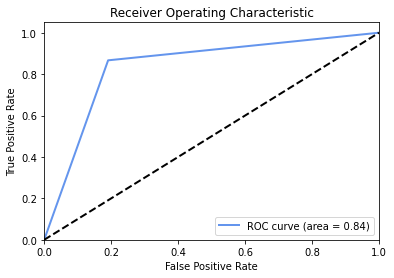

In [22]:
import pandas as pd
test_df = pd.read_csv("dataset_2class/test.csv", header=None)

prec_rec_curve(model, test_df[0], test_df[1])

### Confusion Matrix

In [23]:
from sklearn.metrics import confusion_matrix

y_test_pred = predict_sentiment(model,  test_df[0])
y_test_true = test_df[1]
cm = confusion_matrix(y_test_pred, y_test_true, normalize='true')
cm

array([[0.88118812, 0.11881188],
       [0.21212121, 0.78787879]])

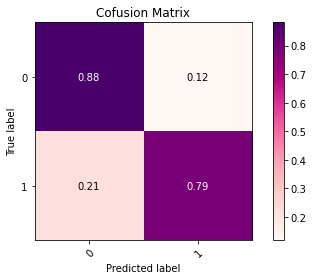

In [24]:
normalize = True
cmap = 'RdPu'
classes = ['0', '1']
title = 'Cofusion Matrix'
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax = ax)
ax.set(xticks = np.arange(cm.shape[1]), yticks = np.arange(cm.shape[0]), xticklabels = classes, yticklabels = classes, ylabel = 'True label', xlabel = 'Predicted label', title = title)
plt.setp(ax.get_xticklabels(), rotation=45, ha = 'right', rotation_mode = 'anchor')
fmt = '.2f' if normalize else 'd'
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt), ha = 'center', va = 'center', color = 'white' if cm[i,j] > thresh else 'black')
        fig.tight_layout()

Text(0, 0.5, 'Loss')

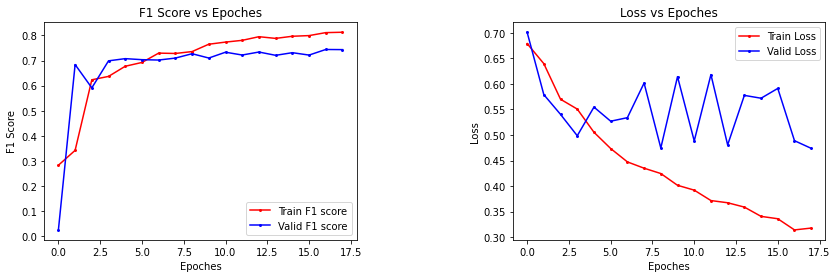

In [25]:
totEpoch = N_EPOCHS
x = range(0, totEpoch)
plt.figure(figsize=(14,4))
grid = plt.GridSpec(3, 2, wspace=0.5, hspace=0.5)
plt.subplot(grid[:,0])
# plt.plot(x, F1_list_train, color="b", marker='o',markersize='1.5',markeredgecolor='b',markeredgewidth = 1.5, label = 'Train F1 score')
plt.plot(x, train_f1, color="r", marker='o',markersize='1.5',markeredgecolor='r',markeredgewidth = 1.5, label = 'Train F1 score')
plt.plot(x, valid_f1, color="b", marker='o',markersize='1.5',markeredgecolor='b',markeredgewidth = 1.5, label = 'Valid F1 score')
plt.legend()
plt.title('F1 Score vs Epoches')
plt.xlabel('Epoches')
plt.ylabel('F1 Score')
plt.subplot(grid[:,1])
plt.plot(x, train_loss, color="red", marker='o',markersize='1.5',markeredgecolor='r',markeredgewidth = 1.5, label = 'Train Loss')
plt.plot(x, valid_loss, color="blue", marker='o',markersize='1.5',markeredgecolor='b',markeredgewidth = 1.5, label = 'Valid Loss')
plt.legend()
plt.title('Loss vs Epoches')
plt.xlabel('Epoches')
plt.ylabel('Loss')

In [30]:
df = pd.read_csv("covidvaccine_tweet_sentiment.csv", header=0)
y_pred = predict_sentiment(model,  df.loc[:, "text"].apply(str))
df['veracity'] = y_pred
df.to_csv("covidvaccine_tweet_sentiment_veracity.csv", index=False)